### Initilization

In [111]:
import pypsa
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

### Scenarios

In [112]:
# --------- 1) Scenarios  ----------
# base:   grid connection
#         CHP 0.635 MW_el, 0.79 MW_th
#         solar_freefield 0.840 MWp
#         nothing extendable
# 2:      grid connection
#         CHP 0.635 MW_el, 0.79 MW_th
#         solar_freefield 0.840 MWp
#         elec flow storage 0.72MWh, 0.12MW
#         nothing extendable
# 3:      grid connection
#         CHP 0.635 MW_el, 0.79 MW_th
#         solar_freefield 0.840 MWp
#         elec flow storage 0.72MWh, 0.12MW
#         rooftop PV extendable
# 4:      No grid connection
#         CHP extendable
#         solar_freefield 0.840 MWp
#         elec flow storage extendable
#         rooftop PV extendable
# 5:      No grid connection
#         CHP extendable
#         solar_freefield 0.840 MWp
#         elec flow storage extendable
#         rooftop PV extendable
#         wind extendable

pars = {
    1: dict(grid=True,  chp_ext=False, solar_roof=False, flow_storage=False, flow_storage_ext=False, wind=False),
    2: dict(grid=True,  chp_ext=False, solar_roof=False, flow_storage=True,  flow_storage_ext=False, wind=False),
    3: dict(grid=True,  chp_ext=False, solar_roof=True,  flow_storage=True,  flow_storage_ext=False, wind=False),
    4: dict(grid=False, chp_ext=True,  solar_roof=True,  flow_storage=True,  flow_storage_ext=True,  wind=False),
    5: dict(grid=False, chp_ext=True,  solar_roof=True,  flow_storage=True,  flow_storage_ext=True,  wind=True)
}

wd = 'C:\\Users\\au710726\\github\\AU-Viborg\\' # working directory

### Data

In [113]:
# Interest rate
ir = 0.07

# Raw cost data
# heat storage (watertank) assumptions: 127L, ΔT 40 K, usable fraction 1, p_nom=5kWh, 172000 eur/MWh = 16200 eur/MWh annulized
data = pd.DataFrame({
    "capex": [400e3, 1000e3, 1100e3, 400e3, 500e3, 172e3, 0],  # eur/MWp eur/L
    "FOM": [10e3, 12e3, 14e3, 14e3, 10e3, 0, 0],  # Fixed O&M (€/MWp/year)
    "opex": [0, 0, 0.05e3, 0.17e3, 0, 0, 0.35e3],  # Variable O&M (€/MWh)
    "lifetime": [35, 35, 27, 20, 20, 20, 1],  # Grid lifetime=1 to avoid div/0
}, index=["PVFree", "PVRoof", "onwind", "CHP", "flow_storage", "thermal_storage", "grid"])

# Annualize CAPEX and add FOM
# For technologies with capital investment: annualized_capex = CAPEX * CRF + FOM
# CRF (Capital Recovery Factor) = ir*(1+ir)^n / ((1+ir)^n - 1)
data["capex_annual"] = data["capex"] * (ir * (1 + ir)**data["lifetime"] / 
                                         ((1 + ir)**data["lifetime"] - 1)) + data["FOM"]

# Grid costs need special handling
# Since PyPSA optimizes per year, we treat the 40 €/kW as an annual capacity cost
grid_capacity_cost = 40e3  # €/MW annual capacity charge
grid_energy_cost = 0.35e3  # €/MWh energy charge

# Wind timeseries
wind_ts = pd.read_csv(f"{wd}/data/Wind_Vestas-V90-2000_2019.csv", comment="#")
wind_ts = wind_ts.set_index("time")
wind_ts.index = pd.to_datetime(wind_ts.index)
wind_ts = wind_ts.drop(columns=["local_time"])
wind_ts["CF"] = wind_ts["electricity"]/2000 # 2000 rated power

# Solar timeseries
solar_dict = {'SE': 2.003, 'S': 1.056, 'SW': 6.643, 'E': 0.731, 'NW': 2.003, 'N': 1.056, 'NE': 6.643, 'W': 0.731} #MW
solar_ts_dict = {}
for loc in solar_dict:  # loop directly over dictionary keys
    files = glob.glob(f"{wd}/data/Solar_{loc}*.csv")
    if not files:
        continue
    ts = pd.read_csv(files[0], skiprows=10, skipfooter=11, engine="python")
    ts["time"] = pd.to_datetime(ts["time"].str.replace(":", ""), format="%Y%m%d%H%M")
    ts["time"] = ts["time"].dt.floor("h")
    ts = ts.set_index("time")
    # Compute capacity factor using the dictionary
    solar_ts_dict[loc] = ts["P"] / (solar_dict[loc] * 1000)
solar_ts = pd.DataFrame(solar_ts_dict) # Combine all location series into one DataFrame

# Heat demand timeseries
L_h = pd.read_excel(f"{wd}/data/Synthese_von_Waermelastprofilen_nach_BDEW.xlsx", sheet_name="Ausgabe")
#L_h["Energie in kWh"].sum() # check if it is 626.57 m3 * 10.16 kWh/m3 = 6365.95 kWh as given in the data
L_h = L_h.rename(columns={"Zeitstempel": "time", "Energie in kWh": "energy"})
L_h = L_h.set_index('time')
L_h.index = pd.to_datetime(L_h.index, unit='h')
L_h.index = L_h.index - pd.DateOffset(years=4) #match 2019 timestamp
L_h = L_h.iloc[:-24] # drop the day after newyears
L_h = L_h/L_h.sum() # normalize 
#L_h = L_h*(626573*0.01016) # new timeseries from known total yearly load
L_h = L_h*(626573*0.01016)/2 # heatload = 0.5 gas consumption

# Power Demand Timeseries
# Based on that there as of now is no CHP (so full elec demand as given by Björn)
L_e = pd.read_excel(f"{wd}/data/N61616_sum_alle_3.xlsx")
L_e = L_e.iloc[:, [4,8]]
L_e = L_e.rename(columns={"Gældende fra": "time", "Sum 61616 ": "energy"}) 
L_e['time'] = pd.to_datetime(L_e['time']).dt.tz_localize("Europe/Copenhagen", ambiguous="NaT", nonexistent="NaT")
L_e['time'] = L_e['time'].dt.tz_convert("UTC")
L_e.index = L_e["time"]
L_e = L_e.drop('time', axis=1)
last_row = L_e.iloc[[-1]].copy()
last_row.index = last_row.index + pd.Timedelta(hours=1)
L_e = pd.concat([L_e, last_row])
L_e.index = wind_ts.index
L_e = L_e/L_e.sum() # normalize to total value
# L_e = L_e*5357.924 # use normalized profile times known yearly sum to get timeseries in kWh
L_e = L_e * (5357.924 + 0.4*(626573*0.01016)) # elecload = elecload+40%gas consumption

### Network setup

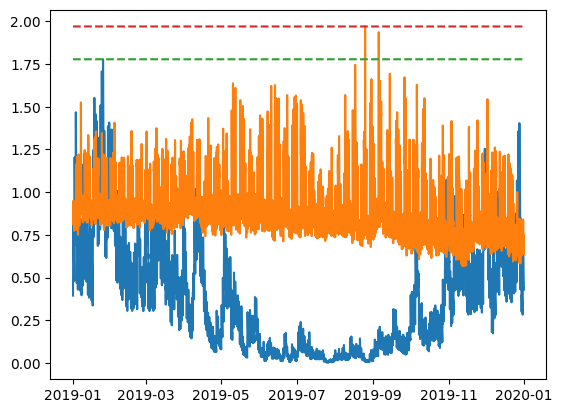

In [114]:
# davon ausgehdend das AU-Viborg zum jetztigen zeitpunkt noch kein CHP hat sind gasverbrauch = heizlast.
# damit muss die chp anlage grösser dimensioniert werden als vom fraunehofer angenommen. nämlich L_h.max()
plt.plot(L_h, label="L_h")
plt.plot(L_e, label="L_e")
plt.plot(L_h.index, np.full(len(L_h), L_h.max()), '--', label="L_h max")
plt.plot(L_h.index, np.full(len(L_e), L_e.max()), '--', label="L_e max")
#plt.legend()
plt.show()

In [115]:
# Choose Scenario
SC = 1 # 1,2,3,4,5
cfg = pars[SC]

In [116]:
# --------- Setup Network ----------
n = pypsa.Network()
n.set_snapshots(wind_ts.index)

# Buses
n.add("Bus", "elec")
n.add("Bus", "heat")
n.add("Bus", "gas")

# Loads (use your actual load data)
n.add("Load", "L_e", bus="elec", p_set=L_e["energy"]*5700/L_e["energy"].sum())
n.add("Load", "L_h", bus="heat", p_set=L_h["energy"]*3300/L_h["energy"].sum())

# --------- Generators ----------
# Grid import
if cfg.get("grid") == True:
      n.add("Carrier", "grid")
      n.add("Generator",
            "grid_import",
            bus="elec",
            carrier="grid",
            p_nom_extendable=True,
            p_nom_max=1e12,
            marginal_cost=grid_energy_cost,  # 0.35e3 eur/MWh
            capital_cost=grid_capacity_cost)  # 40e3 eur/MW annual

# Grid electricity export (elec dump)
n.add("Generator",
      "grid_export",
      bus="elec",
      carrier="grid",
      sign=-1,
      p_nom=1e12,
      p_nom_extendable=True)

# Solar freefield
n.add("Carrier", "solar")
n.add("Generator",
      "solar_S_Free",
      bus="elec",
      carrier="solar",
      p_max_pu=solar_ts["S"]/solar_ts["S"].max(),
      capital_cost=data.at["PVFree", "capex_annual"],
      p_nom = 0.84,
      p_nom_extendable=False,#True,
      p_nom_max=0.84) #MWp

# Solar generators (rooftop)
if cfg.get("solar_roof") == True:
      for loc in solar_ts.columns:
            n.add("Generator",
                  f"solar_{loc}",
                  bus="elec",
                  carrier="solar",
                  p_max_pu=solar_ts[loc],
                  capital_cost=data.at["PVRoof", "capex_annual"],
                  p_nom_extendable=True,
                  p_nom_max=solar_dict[loc])

# Wind
if cfg.get("wind") == True:
      n.add("Carrier", "wind")
      n.add("Generator",
            "wind",
            bus="elec",
            carrier="wind",
            p_max_pu=wind_ts["CF"],
            capital_cost=data.at["onwind", "capex_annual"],
            p_nom_extendable=True,)
            #p_nom_max=2) # own estimate

# Biogas supply
n.add("Carrier", "biogas")
n.add("Generator",
      "biogas_supply",
      bus="gas",
      carrier="biogas",
      p_nom=1e12,
      marginal_cost=0)  # Cost is in CHP operation

# --------- Links ----------
# CHP: gas -> electricity (40%) + heat (50%)
n.add("Carrier", "CHP")
n.add("Link",
      "CHP",
      carrier="CHP",
      bus0="gas",
      bus1="elec",
      bus2="heat",
      p_nom=float(L_h.max())/0.5*1.01,   #1.5875,  # 0.635 MW_el / 0.4 ..... float(L_h.max())/0.5
      efficiency=0.40,
      efficiency2=0.50,
      capital_cost=data.at["CHP", "capex_annual"],  # eur/MW_th/year
      marginal_cost=data.at["CHP", "opex"],  # 0.17e3 eur/MWh biogas cost
      p_nom_extendable=True) #cfg.get("chp_ext"))

# heat storage (watertank)
# assumptions: 127L, ΔT 40 K, usable fraction 1, p_nom=5kWh, 172000 eur/MWh = 16200 eur/MWh annulized
n.add("Carrier", "heat_storage")
n.add("StorageUnit",
    "heat_storage",
    bus="heat",
    carrier="heat_storage",
    max_hours=1.182,
    p_nom=0.005, #5kWh
    capital_cost=data.at["thermal_storage", "capex_annual"],
    efficiency_store=0.95,
    efficiency_dispatch=0.95,
    standing_loss=0.01, #99% efficient
    p_nom_extendable=False,
    cyclic_state_of_charge=True,
)

# heatsink (dump heat)
n.add("Carrier", "heat_sink")
n.add("StorageUnit",
    "heat_sink",
    bus="heat",
    carrier="heat_sink",
    max_hours=1e12,
    p_nom=1e12,
    capital_cost=0,
    efficiency_store=1,
    efficiency_dispatch=0.0001,
    standing_loss=1,
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

# --------- Storage ----------
# Flow storage (battery) - using Store + Links
# Store: holds energy (€/MWh cost)
# Links: charge and discharge (€/kW cost)
if cfg.get("flow_storage") == True:
      n.add("Bus", "battery")

      # Add the Store (energy capacity)
      n.add("Store",
            "flow_storage",
            bus="battery",
            e_nom=0.72,  # Energy capacity in MWh
            e_cyclic=True,  # State of charge is cyclic (end = start)
            capital_cost= data.at["flow_storage", "capex_annual"],  # €/MWh/year
            e_nom_extendable=cfg.get("flow_storage_ext"))

      # Add charging Link (grid -> battery)
      n.add("Link",
            "flow_storage_charge",
            bus0="elec",
            bus1="battery",
            p_nom=0.12,  # Charging power in MW
            efficiency=0.9,  # Charging efficiency
            capital_cost=0)  # €/MW/year for charging
            #p_nom_extendable=cfg.get("flow_storage_ext"))

      # Add discharging Link (battery -> grid)
      n.add("Link",
            "flow_storage_discharge",
            bus0="battery",
            bus1="elec",
            p_nom=0.12,  # Discharging power in MW
            efficiency=0.9,  # Discharging efficiency
            capital_cost=0)  # €/MW/year for discharging
            #p_nom_extendable=cfg.get("flow_storage_ext"))

# Print cost summary
print("\n=== Annualized Costs (€/MW/year or €/MWh) ===")
print(data[["capex", "FOM", "capex_annual", "opex"]])
print(f"\nGrid: {grid_capacity_cost} €/MW + {grid_energy_cost} €/MWh")
print(n.loads_t.p_set)
# print(f"\nFlow storage (Store+Links):")
# print(f"  - Energy: {flow_energy_capex} €/MWh/year for {flow_energy_capacity} MWh")
# print(f"  - Power: {flow_power_capex} €/MW/year for {flow_power_capacity} MW charge/discharge")


=== Annualized Costs (€/MW/year or €/MWh) ===
                     capex      FOM   capex_annual   opex
PVFree            400000.0  10000.0   40893.583860    0.0
PVRoof           1000000.0  12000.0   89233.959649    0.0
onwind           1100000.0  14000.0  105768.307420   50.0
CHP               400000.0  14000.0   51757.170297  170.0
flow_storage      500000.0  10000.0   57196.462872    0.0
thermal_storage   172000.0      0.0   16235.583228    0.0
grid                   0.0      0.0       0.000000  350.0

Grid: 40000.0 €/MW + 350.0 €/MWh
Load                      L_e       L_h
snapshot                               
2019-01-01 00:00:00  0.637569  0.409568
2019-01-01 01:00:00  0.624412  0.525409
2019-01-01 02:00:00  0.603314  0.525409
2019-01-01 03:00:00  0.597950  0.599759
2019-01-01 04:00:00  0.613399  0.756721
...                       ...       ...
2019-12-31 19:00:00  0.523148  0.516402
2019-12-31 20:00:00  0.508425  0.508073
2019-12-31 21:00:00  0.498134  0.477533
2019-12-31 22:0

C:\Users\au710726\AppData\Local\Temp\ipykernel_19556\567990106.py:90: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p_nom=float(L_h.max())/0.5*1.01,   #1.5875,  # 0.635 MW_el / 0.4 ..... float(L_h.max())/0.5


In [117]:
n.optimize(solver_name='gurobi', keep_files=False)
n.export_to_netcdf(f"{wd}/networks/scenario_{SC}_solved.nc")

Index(['elec', 'heat', 'gas'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 28.65it/s]
INFO:linopy.io: Writing time: 1.83s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-03


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-03


Read LP format model from file C:\Users\au710726\AppData\Local\Temp\linopy-problem-ckpeic0_.lp


INFO:gurobipy:Read LP format model from file C:\Users\au710726\AppData\Local\Temp\linopy-problem-ckpeic0_.lp


Reading time = 0.39 seconds


INFO:gurobipy:Reading time = 0.39 seconds


obj: 236525 rows, 96365 columns, 402965 nonzeros


INFO:gurobipy:obj: 236525 rows, 96365 columns, 402965 nonzeros


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 236525 rows, 96365 columns and 402965 nonzeros


INFO:gurobipy:Optimize a model with 236525 rows, 96365 columns and 402965 nonzeros


Model fingerprint: 0x767b5b56


INFO:gurobipy:Model fingerprint: 0x767b5b56


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-01, 1e+12]


INFO:gurobipy:  Matrix range     [4e-01, 1e+12]


  Objective range  [1e+00, 5e+04]


INFO:gurobipy:  Objective range  [1e+00, 5e+04]


  Bounds range     [2e+05, 2e+05]


INFO:gurobipy:  Bounds range     [2e+05, 2e+05]


  RHS range        [7e-05, 1e+12]


INFO:gurobipy:  RHS range        [7e-05, 1e+12]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 198805 rows and 55603 columns


INFO:gurobipy:Presolve removed 198805 rows and 55603 columns


Presolve time: 0.19s


INFO:gurobipy:Presolve time: 0.19s


Presolved: 37720 rows, 40762 columns, 100272 nonzeros


INFO:gurobipy:Presolved: 37720 rows, 40762 columns, 100272 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 2


INFO:gurobipy: Dense cols : 2


 AA' NZ     : 5.937e+04


INFO:gurobipy: AA' NZ     : 5.937e+04


 Factor NZ  : 3.617e+05 (roughly 35 MB of memory)


INFO:gurobipy: Factor NZ  : 3.617e+05 (roughly 35 MB of memory)


 Factor Ops : 5.612e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.612e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.02892672e+17 -2.87180130e+19  1.00e+10 2.91e+02  1.62e+14     0s


INFO:gurobipy:   0   1.02892672e+17 -2.87180130e+19  1.00e+10 2.91e+02  1.62e+14     0s


   1   1.25848626e+17 -5.89111452e+18  1.71e+10 1.48e+04  1.47e+14     0s


INFO:gurobipy:   1   1.25848626e+17 -5.89111452e+18  1.71e+10 1.48e+04  1.47e+14     0s


   2   1.21379802e+17 -4.38924550e+19  2.30e+09 6.39e+03  4.19e+14     0s


INFO:gurobipy:   2   1.21379802e+17 -4.38924550e+19  2.30e+09 6.39e+03  4.19e+14     0s


   3   1.12888984e+17 -2.62069262e+17  2.03e+07 4.11e+01  3.97e+12     0s


INFO:gurobipy:   3   1.12888984e+17 -2.62069262e+17  2.03e+07 4.11e+01  3.97e+12     0s


   4   2.47703651e+16 -1.58009764e+15  3.91e+05 7.10e-09  2.59e+11     0s


INFO:gurobipy:   4   2.47703651e+16 -1.58009764e+15  3.91e+05 7.10e-09  2.59e+11     0s


   5   2.19543969e+11 -4.22252020e+11  7.65e+00 2.95e-08  6.29e+06     0s


INFO:gurobipy:   5   2.19543969e+11 -4.22252020e+11  7.65e+00 2.95e-08  6.29e+06     0s


   6   7.58737172e+06 -2.48169772e+06  7.77e-05 2.55e-11  9.95e+01     0s


INFO:gurobipy:   6   7.58737172e+06 -2.48169772e+06  7.77e-05 2.55e-11  9.95e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.39 seconds (0.36 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.39 seconds (0.36 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   16422    2.0158900e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   16422    2.0158900e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16422 iterations and 0.49 seconds (0.45 work units)


INFO:gurobipy:Solved in 16422 iterations and 0.49 seconds (0.45 work units)


Optimal objective  2.015889976e+06


INFO:gurobipy:Optimal objective  2.015889976e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96365 primals, 236525 duals
Objective: 2.02e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'scenario_1_solved.nc' contains: storage_units, gener

<xarray.Dataset> Size: 2MB
Dimensions:                               (snapshots: 8760,
                                           investment_periods: 0,
                                           storage_units_i: 2,
                                           storage_units_t_p_i: 2,
                                           storage_units_t_p_dispatch_i: 1,
                                           storage_units_t_p_store_i: 2,
                                           ...
                                           links_t_p0_i: 1, links_t_p1_i: 1,
                                           links_t_p2_i: 1, buses_i: 3,
                                           buses_t_p_i: 3,
                                           buses_t_marginal_price_i: 2,
                                           loads_i: 2, loads_t_p_set_i: 2,
                                           loads_t_p_i: 2, carriers_i: 6)
Coordinates: (12/21)
  * snapshots                             (snapshots) int64 70kB 0 1 ... 8759
  * investment_periods                    (investment_periods) object 0B 
  * storage_units_i                       (storage_units_i) object 16B 'heat_...
  * storage_units_t_p_i                   (storage_units_t_p_i) object 16B 'h...
  * storage_units_t_p_dispatch_i          (storage_units_t_p_dispatch_i) object 8B ...
  * storage_units_t_p_store_i             (storage_units_t_p_store_i) object 16B ...
    ...                                    ...
  * buses_t_p_i                           (buses_t_p_i) object 24B 'elec' ......
  * buses_t_marginal_price_i              (buses_t_marginal_price_i) object 16B ...
  * loads_i                               (loads_i) object 16B 'L_e' 'L_h'
  * loads_t_p_set_i                       (loads_t_p_set_i) object 16B 'L_e' ...
  * loads_t_p_i                           (loads_t_p_i) object 16B 'L_e' 'L_h'
  * carriers_i                            (carriers_i) object 48B 'grid' ... ...
Data variables: (12/62)
    snapshots_snapshot                    (snapshots) datetime64[ns] 70kB 201...
    snapshots_objective                   (snapshots) float64 70kB 1.0 ... 1.0
    snapshots_stores                      (snapshots) float64 70kB 1.0 ... 1.0
    snapshots_generators                  (snapshots) float64 70kB 1.0 ... 1.0
    investment_periods_objective          (investment_periods) object 0B 
    investment_periods_years              (investment_periods) object 0B 
    ...                                    ...
    links_t_p2                            (snapshots, links_t_p2_i) float64 70kB ...
    buses_t_p                             (snapshots, buses_t_p_i) float64 210kB ...
    buses_t_marginal_price                (snapshots, buses_t_marginal_price_i) float64 140kB ...
    loads_bus                             (loads_i) object 16B 'elec' 'heat'
    loads_t_p_set                         (snapshots, loads_t_p_set_i) float64 140kB ...
    loads_t_p                             (snapshots, loads_t_p_i) float64 140kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           2015889.9762737444
    network_objective_constant:  185835.34295550565
    network_pypsa_version:       0.34.1
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

In [118]:
n = pypsa.Network(f"{wd}/networks/scenario_1_solved.nc")

INFO:pypsa.io:Imported network scenario_1_solved.nc has buses, carriers, generators, links, loads, storage_units


In [119]:
# Calculate costs
storage_capital_costs = (n.storage_units['capital_cost'] * 
                            (n.storage_units['p_nom_opt'] - n.storage_units['p_nom'])).groupby(n.storage_units['carrier']).sum()
storage_marginal_costs = (n.storage_units['marginal_cost'] * 
                            n.storage_units_t.p.sum(axis=0)).groupby(n.storage_units['carrier']).sum()
generators_capital_costs = (n.generators['capital_cost'] * 
                            (n.generators['p_nom_opt'] - n.generators['p_nom'])).groupby(n.generators['carrier']).sum()
generators_marginal_costs = (n.generators['marginal_cost'] * 
                                n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
AC_line_costs = n.lines.capital_cost.sum()
DC_link_costs = n.links.capital_cost.sum()

# Combine costs into a single DataFrame
storage_costs = pd.DataFrame({
    'Capital': storage_capital_costs,
    'Marginal': storage_marginal_costs
})
generator_costs = pd.DataFrame({
    'Capital': generators_capital_costs,
    'Marginal': generators_marginal_costs
})

In [120]:
n.links.marginal_cost
n.generators_t.p.multiply((n.snapshots[1] - n.snapshots[0]).seconds / 3600).groupby(n.generators.carrier, axis=1).sum().sum()

C:\Users\au710726\AppData\Local\Temp\ipykernel_19556\3780924871.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n.generators_t.p.multiply((n.snapshots[1] - n.snapshots[0]).seconds / 3600).groupby(n.generators.carrier, axis=1).sum().sum()


carrier
biogas    6697.882582
grid      2747.547210
solar      913.595771
dtype: float64

In [121]:
generators_capital_costs = (n.generators['capital_cost'] * (n.generators['p_nom_opt'] - n.generators['p_nom'])).groupby(n.generators['carrier']).sum()
generators_capital_costs
n.links.capital_cost
generators_marginal_costs = (n.generators['marginal_cost'] * n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
generators_marginal_costs

carrier
biogas         0.000000
grid      849589.721143
solar          0.000000
dtype: float64

Generator
grid_import      2427.399203
grid_export       320.148007
solar_S_Free      913.595771
biogas_supply    6697.882582
dtype: float64

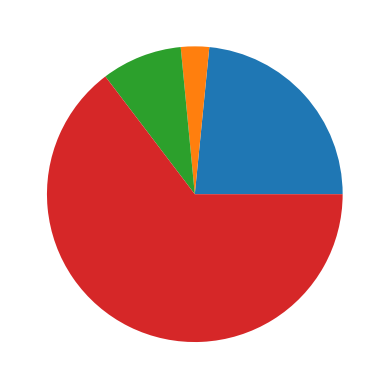

In [122]:
n.generators.p_nom_opt
plt.pie(n.generators_t.p.sum())
n.generators_t.p.sum()

([<matplotlib.patches.Wedge at 0x129ee0d08e0>,
 [Text(-0.32111868977314806, 1.0520849714155112, 'solar_free'),
  Text(-1.070173140456749, -0.2544198291111363, 'import'),
  Text(1.0978291337976742, -0.0690738227192349, 'CHP')],
 [Text(-0.17515564896717165, 0.5738645298630061, '9.4%'),
  Text(-0.5837308038854994, -0.13877445224243795, '38.6%'),
  Text(0.5988158911623677, -0.03767663057412812, '52.0%')])

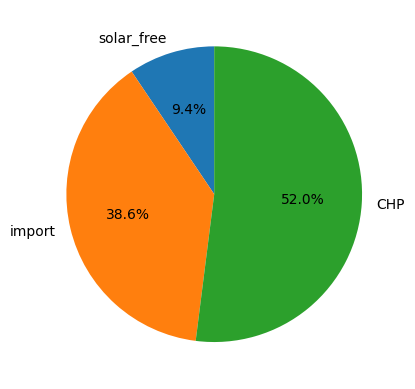

In [123]:
#plt.pie(n.generators_t.p.sum())
tot_gen = pd.DataFrame()
tot_gen.loc[0, "solar_free"] = max(n.generators_t.p["solar_S_Free"].sum() - n.generators_t.p["grid_export"].sum(), 0)
tot_gen.loc[0, "import"] = float(n.generators_t.p["grid_import"].sum())
#tot_gen.loc[0, "export"] = float(n.generators_t.p["grid_export"].sum())
tot_gen.loc[0, "CHP"] = float(-n.links_t.p1.sum().sum() + (n.generators_t.p["solar_S_Free"].sum() - n.generators_t.p["grid_export"].sum()))
tot_gen
plt.pie(
    tot_gen.iloc[0],
    labels=tot_gen.iloc[0].index,   # column names as labels
    autopct="%1.1f%%",     # show percentages
    startangle=90
)

In [124]:
# Calculate costs
storage_capital_costs = (n.storage_units['capital_cost'] * (n.storage_units['p_nom_opt'])).groupby(n.storage_units['carrier']).sum()
storage_marginal_costs = (n.storage_units['marginal_cost'] * n.storage_units_t.p.sum(axis=0)).groupby(n.storage_units['carrier']).sum()
generators_capital_costs = (n.generators['capital_cost'] * (n.generators['p_nom_opt'])).groupby(n.generators['carrier']).sum()
generators_marginal_costs = (n.generators['marginal_cost'] * n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
link_capital_costs = n.links['capital_cost'] * (n.links['p_nom_opt']).groupby(n.links['carrier']).sum()
link_marginal_costs = n.links['marginal_cost'] * n.links_t.p0.sum(axis=0).groupby(n.links['carrier']).sum()

# Combine costs into a single DataFrame
capital_costs = (
    storage_capital_costs
    .add(generators_capital_costs, fill_value=0)
    .add(link_capital_costs, fill_value=0)
)

marginal_costs = (
    storage_marginal_costs
    .add(generators_marginal_costs, fill_value=0)
    .add(link_marginal_costs, fill_value=0)
)
costs_df = pd.DataFrame({
    "Capital costs": capital_costs,
    "Marginal costs": marginal_costs
}).T

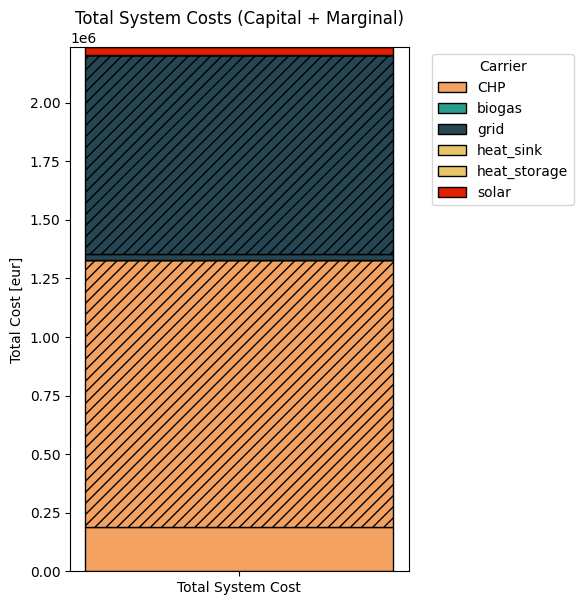

In [125]:
# --- Combine data ---
# assuming you already have these Series:
# capital_costs, marginal_costs

carriers = capital_costs.index
colors = ['#f4a261', '#2a9d8f', '#264653', '#e9c46a', '#e9c46a','#e11f01'][:len(carriers)]

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(6,6))

bottom = 0
bars = []

for carrier, color in zip(carriers, colors):
    cap = capital_costs[carrier]
    mar = marginal_costs.get(carrier, 0)

    # Capital cost (solid color)
    bar_cap = ax.bar(0, cap, bottom=bottom, color=color, edgecolor='black')
    bottom += cap

    # Marginal cost (same color, hatched)
    bar_mar = ax.bar(0, mar, bottom=bottom, color=color, edgecolor='black', hatch='///')
    bottom += mar

    bars.append(bar_cap)

# --- Style and labels ---
ax.set_xticks([0])
ax.set_xticklabels(["Total System Cost"])
ax.set_ylabel("Total Cost [eur]")
ax.set_title("Total System Costs (Capital + Marginal)")

# Legend: one entry per carrier
legend_labels = [f"{carrier}" for carrier in carriers]
ax.legend(bars, legend_labels, title="Carrier", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [126]:
len(carriers)

6

In [127]:
n.generators.p_nom_opt

Generator
grid_import      5.813483e-01
grid_export      9.084606e-01
solar_S_Free     8.400000e-01
biogas_supply    1.000000e+12
Name: p_nom_opt, dtype: float64

In [128]:
n.generators.p_nom_max

Generator
grid_import      1.000000e+12
grid_export               inf
solar_S_Free     8.400000e-01
biogas_supply             inf
Name: p_nom_max, dtype: float64

In [129]:
n.generators.p_nom

Generator
grid_import      0.000000e+00
grid_export      1.000000e+12
solar_S_Free     8.400000e-01
biogas_supply    1.000000e+12
Name: p_nom, dtype: float64

In [130]:
n.generators.p_nom_extendable

Generator
grid_import       True
grid_export       True
solar_S_Free     False
biogas_supply    False
Name: p_nom_extendable, dtype: bool

<Axes: xlabel='snapshot'>

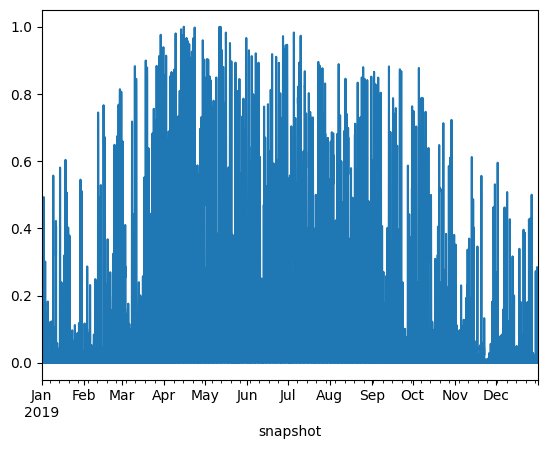

In [131]:
n.generators_t.p_max_pu['solar_S_Free'].plot()

In [132]:
n.generators_t.p_max_pu['solar_S_Free'].mean()

0.12415685080545541

In [133]:
solar_ts['S'].max()

1601.0153503787878

In [134]:
n.loads_t.p_set.sum()

Load
L_e    5700.0
L_h    3300.0
dtype: float64

In [135]:
n.generators.p_nom_opt

Generator
grid_import      5.813483e-01
grid_export      9.084606e-01
solar_S_Free     8.400000e-01
biogas_supply    1.000000e+12
Name: p_nom_opt, dtype: float64

In [138]:
n.generators_t.p['solar_S_Free']-n.generators_t.p_min_pu['solar_S_Free']*n_generators<<<<<<

snapshot
2019-01-01 00:00:00    0.0
2019-01-01 01:00:00    0.0
2019-01-01 02:00:00    0.0
2019-01-01 03:00:00    0.0
2019-01-01 04:00:00    0.0
                      ... 
2019-12-31 19:00:00    0.0
2019-12-31 20:00:00    0.0
2019-12-31 21:00:00    0.0
2019-12-31 22:00:00    0.0
2019-12-31 23:00:00    0.0
Name: solar_S_Free, Length: 8760, dtype: float64